# Long notebook for group 16

> Group 16 : Laure Beringer, Hasse Rombouts, Henrik Fjellheim

In this notebook we will present all the experiments we've tried for the project of the TDT4173 Machine Learning course.  
This notebook will develop in order:
1. [EDA](#eda)
2. [Models](#models)
3. [Ensemble of models](#ensemble-of-models)


Imports and main commun functions:

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import json
import seaborn as sns

import plotly.express as px
import matplotlib.pylab as plt
plt.style.use('ggplot')

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

## EDA

This part will contain :
1. [Loading and description of the data](#loading-and-description-of-the-data)
2. [Missing values](#missing-values)
3. [Feature engineering](#feature-engineering)

### Loading and description of the data

#### Loading

Loading and merging of the data:

In [3]:
# Reading the datasets
# Metadata
metaData_apartment = pd.read_json('data/apartments_meta.json')
metaData_building = pd.read_json('data/buildings_meta.json')
metaData = pd.concat([metaData_apartment, metaData_building])

# train
train_apartment = pd.read_csv('data/apartments_train.csv')
train_building = pd.read_csv('data/buildings_train.csv')
df_train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
df_train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
df_train.drop('id_y', axis=1, inplace=True)

# test
test_apartment = pd.read_csv('data/apartments_test.csv')
test_building = pd.read_csv('data/buildings_test.csv')
df_test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
df_test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
df_test.drop('id_y', axis=1, inplace=True)

df_all = pd.concat([df_train, df_test])

Genral information about the data:

In [4]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['price'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print('Train columns \n', list(df_train.columns))
print('Test columns \n', list(df_test.columns))

Number of Training Examples = 23285
Number of Test Examples = 9937

Training X Shape = (23285, 34)
Training y Shape = 23285

Test X Shape = (9937, 33)
Test y Shape = 9937

Train columns 
 ['apartment_id', 'seller', 'price', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']
Test columns 
 ['apartment_id', 'seller', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 'constructed', 'mater

#### Description

Functions to describe each colmuns of the data using the metadata:

In [5]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

Description of the apartment data:

In [6]:
print(f'Loaded {len(train_apartment)} apartments')
# metadata as json
with open('data/apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(train_apartment, apartments_meta)

Loaded 23285 apartments


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID for apartment,#unique=23285
seller,categorical,8830,The type of apartment seller,"Agents(1895), Company(4768), Developer(6185), Owner(1607)"
price,real,0,The listed price of the apartment (TARGET),"mean=23556173.5, std=52643927.8, min=900000.0, max=2600000000.0"
area_total,real,0,Total area of the apartment,"mean=74.5, std=58.7, min=9.3, max=2181.0"
area_kitchen,real,4721,Total kitchen area in the apartment,"mean=12.6, std=6.6, min=1.0, max=100.0"
area_living,real,3882,Total living space area in the apartment,"mean=38.7, std=31.4, min=0.0, max=900.0"
floor,integer,0,Primary building floor of the apartment,"mean=9.0, std=8.3, min=1.0, max=95.0"
rooms,integer,0,Number of rooms in the apartment,"mean=2.2, std=1.1, min=1.0, max=6.0"
layout,categorical,17642,Overal apartment layout,"Adjacent(241), Adjacent_isolated(465), Isolated(4937)"
ceiling,real,11093,Ceiling height in the apartment,"mean=3.3, std=10.8, min=0.0, max=340.0"


We can see that the features with no nan values are : id, price, area_total, floor, rooms and building_id.  
The categorical features are : seller, layout and condition.

Description of the building data:

In [7]:
print(f'Loaded {len(train_building)} building')
# metadata as json
with open('data/buildings_meta.json') as f: 
    building_meta = json.load(f)
describe_data(train_building, building_meta)

Loaded 6791 building


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID of building for joining with apartments,#unique=6791
new,boolean,227,Whether it is an old or new building,"False(6141), True(423)"
latitude,real,0,Latitude coordinate of building,"mean=55.7, std=0.1, min=55.2, max=56.0"
longitude,real,0,Longitude coordinate of building,"mean=37.6, std=0.2, min=36.9, max=38.0"
district,categorical,1,Administriative district within Moscow,"Central(637), East(956), North(593), North-East(630), North-West(553), Novomoskovsk(344), South(758), South-East(672), South-West(900), Troitsk(146), West(535), Zelenograd(66)"
street,string,0,Bulding street name,#unique=1682
address,string,0,Building address (within street),#unique=1851
constructed,integer,479,Year when the building was constructed,"mean=1985.8, std=24.3, min=1855.0, max=2023.0"
material,categorical,1165,Primary building material used in building,"Block(679), Bricks(1226), Monolith(1312), Monolithic_brick(19), Panel(2384), Stalin_project(2), Wood(4)"
stories,integer,0,Total number of floors in the building,"mean=13.0, std=7.0, min=1.0, max=95.0"


We can see that the features with no nan values are : id, latitude, longitude, street, address and stories.  
The categorical features are : district, material, parking and heating

#### First plots

##### Price distribution

Text(0.5, 1.0, 'Distribution of train set prices after log transform')

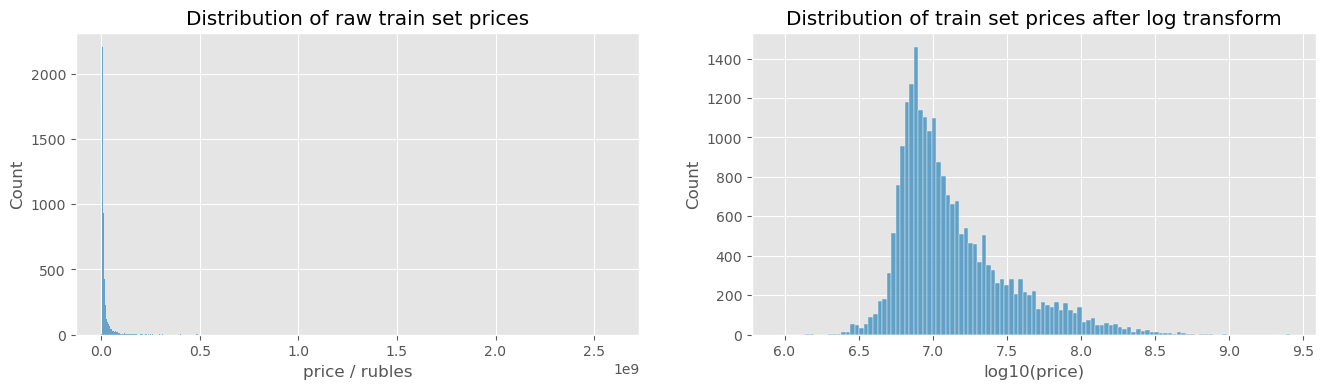

In [8]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.histplot(df_train.price.rename('price / rubles'), ax=ax1)
ax1.set_title('Distribution of raw train set prices')
sns.histplot(np.log10(df_train.price).rename('log10(price)'), ax=ax2)
ax2.set_title('Distribution of train set prices after log transform')

##### Apartments position with price

(<AxesSubplot:title={'center':'Moscow apartment price by location'}, xlabel='longitude', ylabel='latitude'>,
 <matplotlib.colors.Normalize at 0x183e85e53a0>)

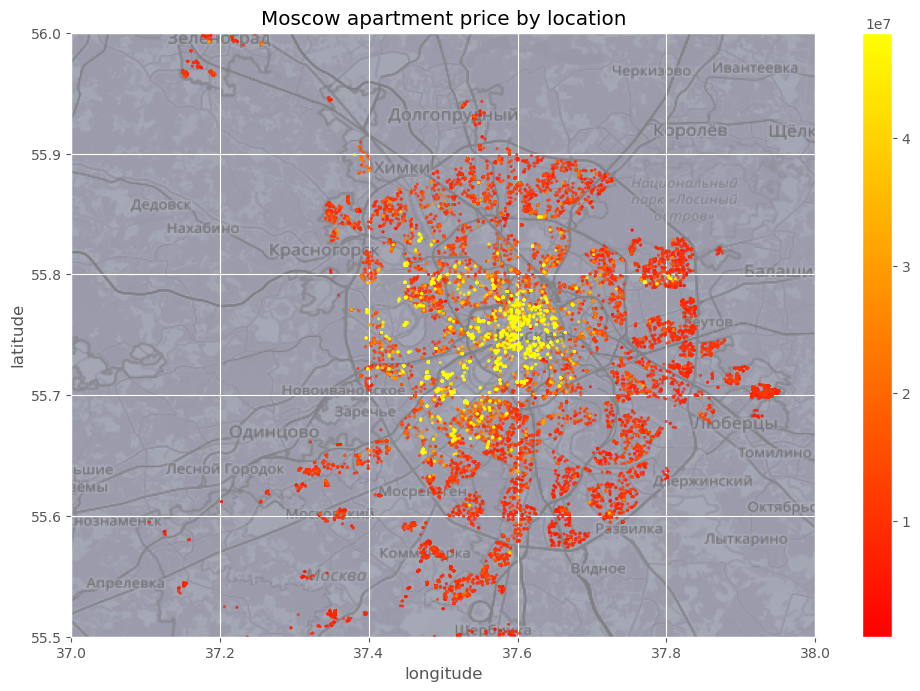

In [9]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(df_train)

In [10]:
# TODO : do we want to keep this map ?

# from folium import Choropleth, Circle, Marker
# from folium.plugins import HeatMap, MarkerCluster
# import math

# def preprocess(df) :
#     df = df[['district','latitude','longitude','price']]
#     df = df.replace('NA', np.nan)
#     df.dropna(subset=['latitude'], inplace=True)
#     df.dropna(subset=['price'], inplace=True)
#     df["latitude"] = df["latitude"].astype(float)
#     df["longitude"] = df["longitude"].astype(float)
#     return df

# map1_df = preprocess(df_train)

# city_map = folium.Map(location=[55.75,37.62], zoom_start=11.2, tiles='Stamen Terrain')
# mc = MarkerCluster()
# for idx, row in map1_df.iterrows():
#     if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
#         popup = """
#         District : <b>%s</b><br>
#         Price : <b>%s</b><br>
#         """ % (row['district'], row['price'])
#         mc.add_child(Marker([row['latitude'], row['longitude']],tooltip=popup))
#     city_map.add_child(mc)
# city_map

### Missing values

Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33
Features with no missing values: ['apartment_id', 'price', 'area_total', 'floor', 'rooms', 'building_id', 'latitude', 'longitude', 'street', 'address', 'stories']


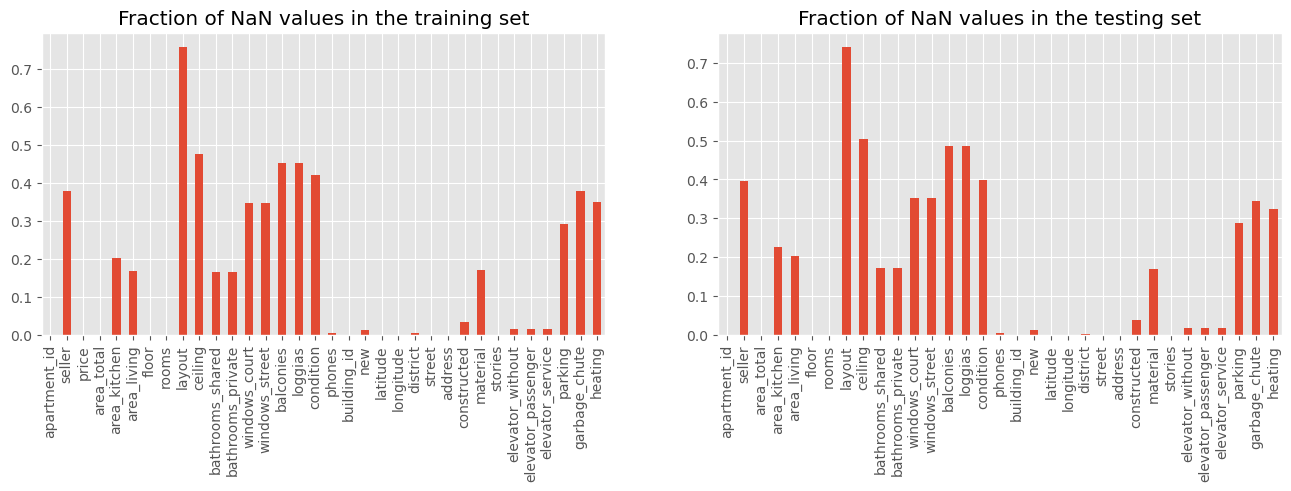

In [11]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Training set features with any missing value: {df_train.isna().any().sum()}/{df_train.shape[1]}')
print(f'Testing set features with any missing value: {df_test.isna().any().sum()}/{df_test.shape[1]}')
df_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
df_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

featuresNA = dict(df_train.isna().any())
featuresNoNA = []
for key in featuresNA.keys():
    if not featuresNA[key] : featuresNoNA.append(key)
print('Features with no missing values:', featuresNoNA)
#print(~df_train.isna().all())

#### Area_living

C:\Users\Laure\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


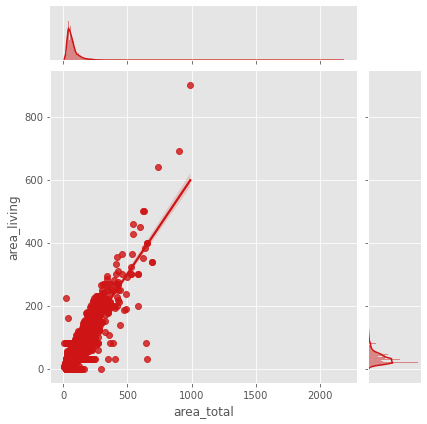

In [12]:
sns.jointplot(df_train.loc[:,'area_total'], df_train.loc[:,'area_living'], kind="reg", color="#ce1414")

There is a clear link between area_total and area_living is very clear. So we can use area_total to complete area_living.

#### Area_kitchen

In [13]:
fig = px.scatter_3d(df_train, x='area_kitchen', y='area_total', z='area_living',
              color='area_kitchen')
fig.show()

We can clearly see a plane between those three features. We can then deduce the missing values of the feature area_kitchen with the values of the features area_total and area_living.

### Outliers removal

### Feature engineering

#### Feature Correlation

Text(0.5, 1.0, 'Correlations all data')

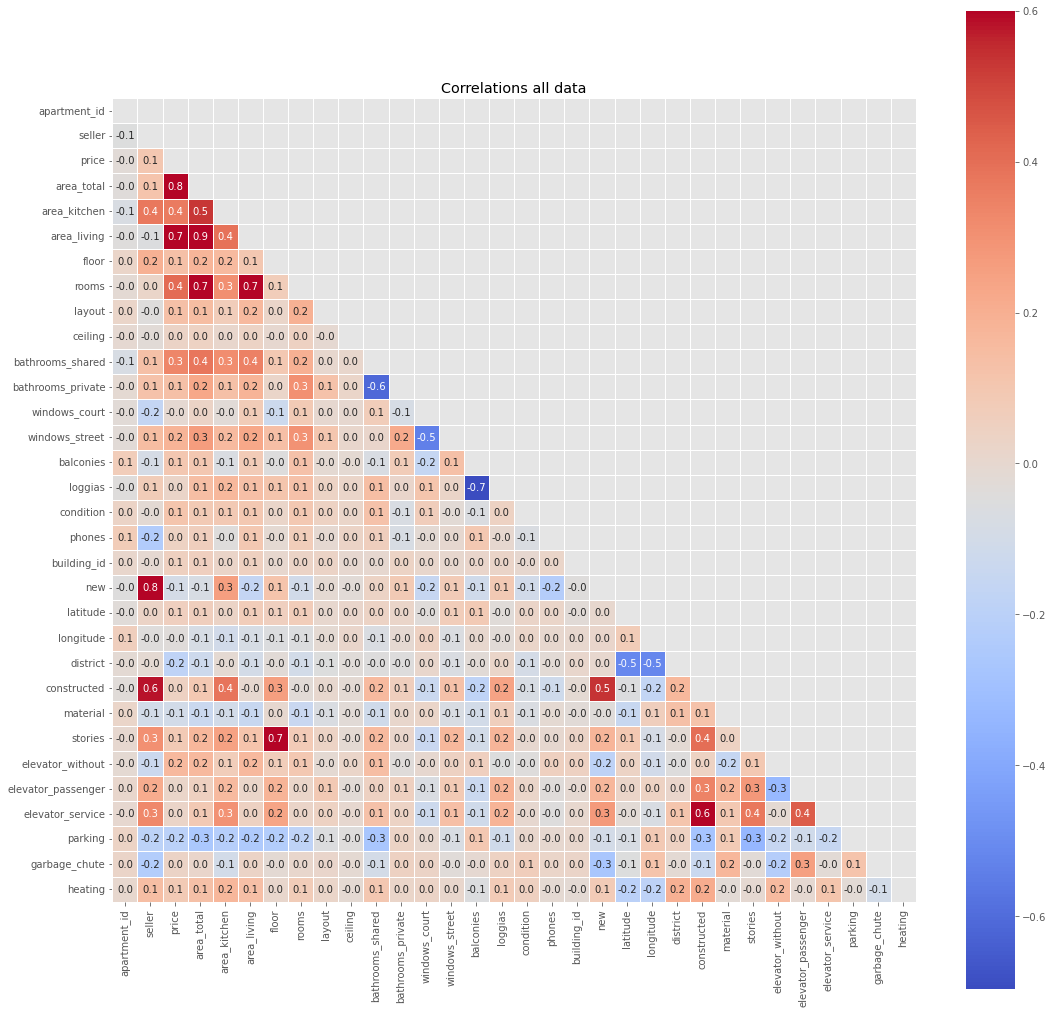

In [14]:
corr = df_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_train.corr(), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlations all data')

Text(0.5, 1.0, 'Features Correlating with price')

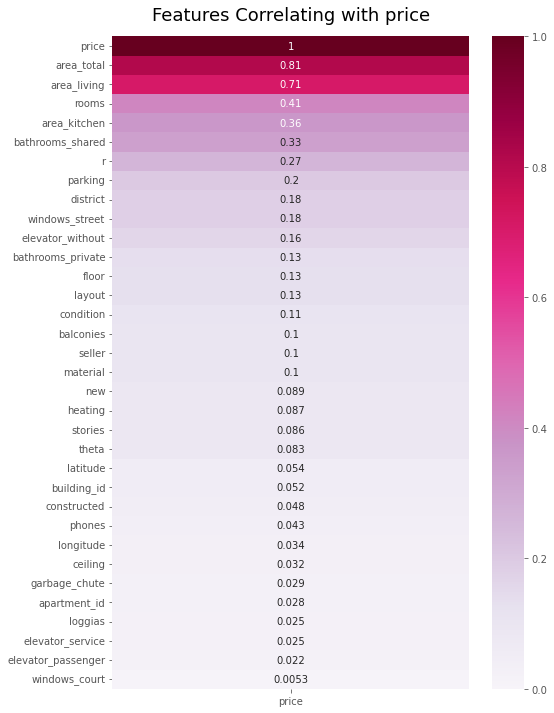

In [27]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(abs(df_train.corr()[['price']]).sort_values(by='price', ascending=False), vmin=0, vmax=1, annot=True, cmap='PuRd')
heatmap.set_title('Features Correlating with price', fontdict={'fontsize':18}, pad=16)

The features area_total and rooms have no missing values and correlate strongly with the price. These will be the main features. (area_living and area_kitchen are very correlated to area_total so they may not be very useful)

#### New features

##### R and Theta

Since the city of Moscow is pretty close to a center and the most expensive apartments are in the center, we though it would be more representative to use r and theta (radius and angle) for the apartment position instead of latitude and longitude. We also moved the origin of latitude and longitude to the mean.  
Those two new features are created as followed:

In [16]:
# Move origin to mean
df_train['latitude'] = df_train['latitude'] - df_train['latitude'].mean()
df_train['longitude'] = df_train['longitude'] - df_train['longitude'].mean()
df_test['latitude'] = df_test['latitude'] -  df_test['latitude'].mean()
df_test['longitude'] = df_test['longitude'] -  df_test['longitude'].mean()

# Convert to polar coordinates
df_train['r'] =  np.sqrt(df_train['latitude']**2 + df_train['longitude']**2)
df_train['theta'] = np.arctan(df_train['longitude']/df_train['latitude'])
df_test['r'] =  np.sqrt(df_test['latitude']**2 + df_test['longitude']**2)
df_test['theta'] = np.arctan(df_test['longitude']/df_test['latitude'])

We can see that we get better corrllation with price using those features:

Text(0.5, 1.0, 'Features Correlating with price')

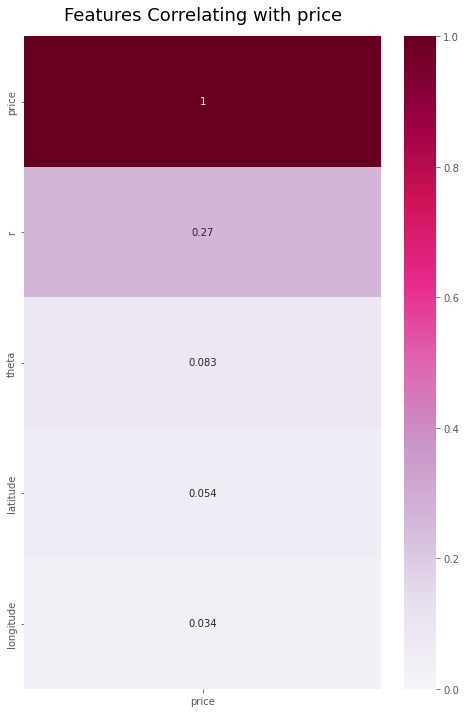

In [28]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(abs(df_train[['latitude', 'longitude', 'r', 'theta', 'price']].corr()[['price']]).sort_values(by='price', ascending=False), vmin=0, vmax=1, annot=True, cmap='PuRd')
heatmap.set_title('Features Correlating with price', fontdict={'fontsize':18}, pad=16)

## Models

### Random forest

> Student: Laure Beringer  

I started using this model this the beginning of thsi project and used the class RandomForestRegressor from the library sklearn.

In [ ]:
model = RandomForestRegressor(
        n_estimators=2000,
        max_depth=400,
        min_samples_split=2,
        min_samples_leaf= 2,
        min_weight_fraction_leaf=0.00008,
        max_features='auto',
        max_leaf_nodes=None,
        min_impurity_decrease=1100,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=True,
        ccp_alpha=20000,
        max_samples=None
    )
features = ["area_total", "latitude", "longitude", "floor", "district", "stories", 'condition']

### K nearest neighbors

## Ensemble of models